### Overview

This notebook is the continuation of Value_at_Risk(2). In the previous notebooks, different methods for calculating K-day VaR for one security are introduced. However, in reality, we also care about the VaR value of a portfolio consisting of more than one securities. Note that the securities in the portfolio are usually correlated in some ways. Therefore, the VaR of a portfolio may not be the weighted sum of VaR of each security in the portfolio. This notebook will demostrate some techniques for calculating the VaR of a portfolio which contains two securities -- Hang Seng Index fund and Nikkei 225 index fund.

##### Note: VaR is treated as negative value in this notebook (although it is defined as positive number by convention)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arch
import datetime
from scipy.stats import norm
from scipy import optimize

### Data

The Hang Seng Index(HSI) and Nikkei 225(N225) data from year 2010 to 2021 are used in this notebook. The data are obtained from Yahoo Finance.

In [2]:
df_hsi = pd.read_csv('HSI_2010_2021.csv')
df_hsi['Date'] = pd.to_datetime(df_hsi['Date'], format='%Y-%m-%d')
df_hsi.dropna(subset=['Close'],inplace=True)

In [3]:
df_n225 = pd.read_csv('N225_2010_2021.csv')
df_n225['Date'] = pd.to_datetime(df_n225['Date'], format='%Y-%m-%d')
df_n225.dropna(subset=['Close'],inplace=True)

Combine two DataFrame together and only use close price to calculate VaR.

In [4]:
df1 = df_hsi[['Date', 'Close']].copy()
df2 = df_n225[['Date', 'Close']].copy()
df1.rename(columns = {'Close':'hsi'}, inplace=True)
df2.rename(columns ={'Close': 'n225'}, inplace=True)

In [5]:
df_all = pd.merge(df1,df2, on='Date')
df_all.dropna(inplace=True)
df_all

,Date,hsi,n225
0,2010-01-04,21823.279297,10654.790039
1,2010-01-05,22279.580078,10681.830078
2,2010-01-06,22416.669922,10731.450195
3,2010-01-07,22269.449219,10681.660156
4,2010-01-08,22296.750000,10798.320313
...,...,...,...
2775,2021-12-23,23193.640625,28798.369141
2776,2021-12-24,23223.759766,28782.589844
2777,2021-12-28,23280.560547,29069.160156
2778,2021-12-29,23086.539063,28906.880859


Text(0.5, 1.0, 'HSI and N225 Index')

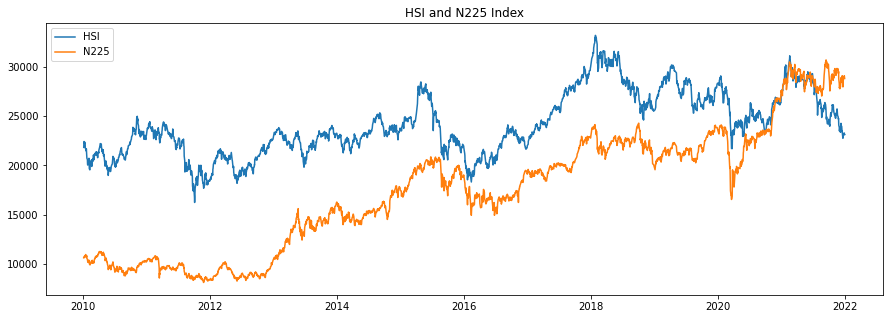

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(df_all['Date'], df_all['hsi'], label='HSI')
plt.plot(df_all['Date'], df_all['n225'], label='N225')
plt.legend()
plt.title('HSI and N225 Index')

In [7]:
df_all.corr()

,hsi,n225
hsi,1.00000,0.76206
n225,0.76206,1.00000


It is worth noting that HSI and N225 are positively correlated. The correlation between two securities should be considered when we calculate the VaR of the portfolio.

### Monte Carlo Simulation with Dynamic Correlations

In the previous notebook, Monte Carlo Simulation is introduced to calculate the K-day VaR of the portfolio consisting only one security. When there are more than one security, the method for generating the artificial returns for each security is modified so that correlation is taken into consideration. 

First, let's express the n-asset return as vector form.  Then the covariance matrix of the return can be written as


where 

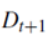 is a diagonal matrix containing the dynamic standard deviations on the diagonal, and zeros on the off diagonal,

and

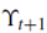 is a matrix containing the asset correlations on the off diagonals and ones on the diagonal.

For example, when there are two assets for consideration, 

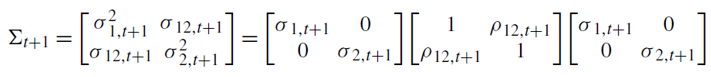

Second, recall that in the previous notebooks, we simulate the daily return by multiplying standard deviation with random number drawn from normal distribution. The same idea is used in multivariate case. The daily return vector is calculated by

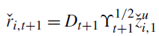

where 

 is uncorrelated standard normal random vector.

Third, in order to calculate the return vector in next day, we need to estimate the variance and correlation in next day. As for the variances of each asset, they are estimated by GARCH model, just like what we did in the previous notebooks. Regrading the correlation, we can use mean-reverting GARCH to estimate the correlation in next day. The calculation is as follows.


where 

 is standardized returns of asset j, 

and

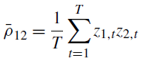

Then, we need to do the normalization to calculate the correlation.

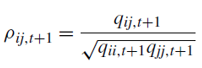

Finally, we can repeat the above steps to calculate the K-period return for each asset. 

##### Code

In [8]:
# Calculate the log return for each asset
df = df_all.copy()
df['hsi_ret'] = np.log(df['hsi']/df['hsi'].shift(1))
df['n225_ret'] = np.log(df['n225']/df['n225'].shift(1))
df.dropna(inplace=True)
df = df.set_index('Date')
df

,hsi,n225,hsi_ret,n225_ret
Date,,,,
2010-01-05,22279.580078,10681.830078,0.020693,0.002535
2010-01-06,22416.669922,10731.450195,0.006134,0.004635
2010-01-07,22269.449219,10681.660156,-0.006589,-0.004650
2010-01-08,22296.750000,10798.320313,0.001225,0.010862
2010-01-12,22326.640625,10879.139648,0.001340,0.007457
...,...,...,...,...
2021-12-23,23193.640625,28798.369141,0.003945,0.008234
2021-12-24,23223.759766,28782.589844,0.001298,-0.000548
2021-12-28,23280.560547,29069.160156,0.002443,0.009907


In [9]:
# Train the GARCH model to fit the variance of HSI return, 
# and then calculate the standardized return by dividing the return with standard deviation
# Also, obtain the estimation of variance on the next day of last date in df
model_hsi = arch.arch_model(df['hsi_ret'], rescale=False)
res_hsi = model_hsi.fit(last_obs=df.index[-1])
forecasts_hsi = res_hsi.forecast(horizon=5, start=df.index[0], reindex=False) 
tmr_variance_hsi = forecasts_hsi.variance['h.1'] # will be used as initial variance of HSI in simulation
lastest_variance_hsi = tmr_variance_hsi.iloc[-1]
df['tdy_hsi_sd'] = np.sqrt(tmr_variance_hsi.shift(1))
df['hsi_z'] = df['hsi_ret']/df['tdy_hsi_sd']

# Train the GARCH model to fit the variance of N225 return, 
# and then calculate the standardized return by dividing the return with standard deviation
# Also, obtain the estimation of variance on the next day of last date in df
model_n225 = arch.arch_model(df['n225_ret'], rescale=False)
res_n225 = model_n225.fit(last_obs=df.index[-1])
forecasts_n225 = res_n225.forecast(horizon=5, start=df.index[0], reindex=False) 
tmr_variance_n225 = forecasts_n225.variance['h.1'] # will be used as initial variance of N225 in simulation
lastest_variance_n225 = tmr_variance_n225.iloc[-1]
df['tdy_n225_sd'] = np.sqrt(tmr_variance_n225.shift(1))
df['n225_z'] = df['n225_ret']/df['tdy_n225_sd']

df.dropna(inplace=True)
df

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12916604338.337633
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1196474433969691.5
Iteration:      3,   Func. Count:     31,   Neg. LLF: 253944432.97254136
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8459.030407504139
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5.724217185414257e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4.693247551403794e+22
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.141029646788411e+22
Iteration:      4,   Func. Count:     49,   Neg. LLF: 1.0848389925184233e+23
Iteration:      5,   Func. Count:     64,   Neg. LLF: 5.3053728360446784e+17
Iteration:      6,   Func. Count:     76,   Neg. LLF: -8235.514202909702
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8235.51419787167
          

,hsi,n225,hsi_ret,n225_ret,tdy_hsi_sd,hsi_z,tdy_n225_sd,n225_z
Date,,,,,,,,
2010-01-06,22416.669922,10731.450195,0.006134,0.004635,0.014066,0.436105,0.011413,0.406081
2010-01-07,22269.449219,10681.660156,-0.006589,-0.004650,0.013735,-0.479731,0.010953,-0.424600
2010-01-08,22296.750000,10798.320313,0.001225,0.010862,0.013444,0.091129,0.010591,1.025661
2010-01-12,22326.640625,10879.139648,0.001340,0.007457,0.013080,0.102423,0.010623,0.701919
2010-01-13,21748.599609,10735.030273,-0.026231,-0.013335,0.012732,-2.060273,0.010377,-1.285078
...,...,...,...,...,...,...,...,...
2021-12-23,23193.640625,28798.369141,0.003945,0.008234,0.011929,0.330671,0.014102,0.583903
2021-12-24,23223.759766,28782.589844,0.001298,-0.000548,0.011660,0.111301,0.013583,-0.040351
2021-12-28,23280.560547,29069.160156,0.002443,0.009907,0.011376,0.214725,0.012894,0.768337


In [10]:
# Parameters of GARCH model for HSI
res_hsi.params

mu          0.000293
omega       0.000003
alpha[1]    0.050000
beta[1]     0.930000
Name: params, dtype: float64

In [11]:
# Parameters of GARCH modelfor N225
res_n225.params

mu          0.000672
omega       0.000004
alpha[1]    0.100000
beta[1]     0.880000
Name: params, dtype: float64

In [12]:
# Using mean-reverting GARCH to calculate the daily correlation recurrsively starting from first row of df
# return the parameters for calculating the correlation on the next day of last date in df. 
# they will be used as the initial value in simulation
def latest_corr(alpha, beta, df):
    q11 = 1   # initial value of q11
    q22 = 1   # initial value of q22
    rho = np.mean(df['n225_z']*df['hsi_z'])
    q12 = rho  # initial value of q12
    q11_log = [1]
    q22_log = [1]
    q12_log = [q12]
    for idx, row in df.iterrows():
        q11 = 1 + alpha*((row['hsi_z'])**2-1) + beta*(q11-1)
        q22 = 1 + alpha*((row['n225_z'])**2-1) + beta*(q22-1)
        q12 = rho + alpha*(row['n225_z']*row['hsi_z']-rho) + beta*(q12-rho)
        q11_log.append(q11)
        q22_log.append(q22)
        q12_log.append(q12)
    latest_q11 = q11_log.pop()
    latest_q22 = q22_log.pop()
    latest_q12 = q12_log.pop()
    df['q11'] = q11_log
    df['q22'] = q22_log
    df['q12'] = q12_log
    df['corr'] = df['q12']/np.sqrt(df['q11']*df['q22'])
    return latest_q11, latest_q22, latest_q12, rho, df

In [13]:
# To calculate the likelihood of mean-reverting GARCH model for given alpha and beta 
def likelihood_GARCH(params, *arg):
    alpha = params[0]
    beta = params[1]
    df = arg[0]
    if alpha + beta >1:
        return 10000
    q11, q22, q12, rho, df = latest_corr(alpha, beta, df)
    z1 = df['hsi_z']
    z2 = df['n225_z']
    corr = df['corr']
    likelihood = -1/2 * np.sum(np.log(1-corr**2)+(z1**2 + z2**2 - 2*corr*z1*z2)/(1-corr**2))
    return -likelihood

In [14]:
# To estimate the alpha and beta in mean-reverting GARCH model by MLE
df_tmp = df.copy()
res = optimize.fmin(likelihood_GARCH, np.array([0.05,0.9]), args=(df_tmp,), ftol = 0.000000001)
alpha = res[0]
beta = res[1]
print('alpha =', alpha)
print('beta =', beta)

Optimization terminated successfully.
         Current function value: 2325.328376
         Iterations: 51
         Function evaluations: 94
alpha = 0.014204500090155555
beta = 0.9722172637875326


In [15]:
df_tmp = df.copy()
q11, q22, q12, rho, df_tmp = latest_corr(alpha , beta, df_tmp)  # calculate the initial value of parameters used in the simulation

Text(0, 0.5, 'Correlation')

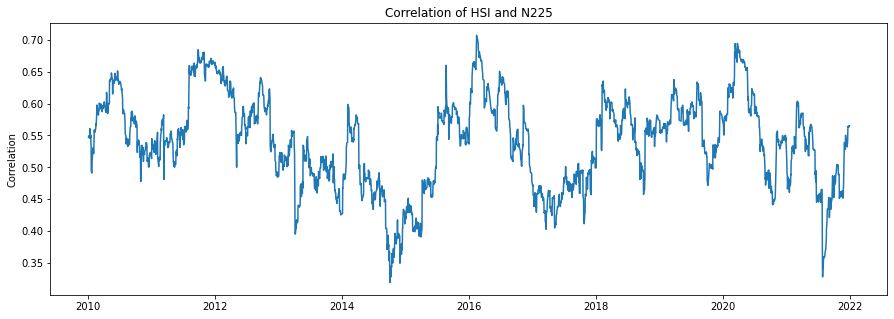

In [16]:
# Visualize the daily correlation estimated by mean-reverting GARCH model
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(df_tmp['corr'])
plt.title('Correlation of HSI and N225')
plt.ylabel('Correlation')

In [17]:
# Run the simulation to calculate the K-day return of two assets

K = 40    # calculate K-day VaR
N = 10000    # run simulation for N times
returns_hsi = []   # record N simulations of K-period returns of HSI
returns_n225 = []   # record N simulations of K-period returns of N225
for i in range(N):
    r_hsi = 0  # cummulated return of HSI
    hist_hsi = [0]  # record the cummulated return of HSI
    r_n225 = 0   # cummulated return of N225
    hist_n225 = [0]   # record the cummulated return of N225
    variance_hsi = lastest_variance_hsi
    variance_n225 = lastest_variance_n225
    q11_t = q11
    q22_t = q22
    q12_t = q12
    for j in range(K):
        p12_t = q12_t/(q11_t*q22_t)**0.5  # calculate correlation of HSI and N225 by normalization
        Z = np.random.normal(size=(2,1))  # generate normal random vector
        Y = np.array([[1, 0],
                      [p12_t, (1-p12_t**2)**0.5]])    
        D = np.array([[variance_hsi**0.5,0],
                      [0, variance_n225**0.5]])
        R = D.dot(Y).dot(Z)  # calculate return vector
        r_hsi += R[0][0] + res_hsi.params['mu']   
        r_n225 += R[1][0] + res_n225.params['mu']
        hist_hsi.append(r_hsi)
        hist_n225.append(r_n225)
        # update parameters for calculating return vector in next day
        variance_hsi = res_hsi.params['omega'] + res_hsi.params['alpha[1]']*(R[0][0]**2) + res_hsi.params['beta[1]']*variance_hsi
        variance_n225 = res_n225.params['omega'] + res_n225.params['alpha[1]']*(R[1][0]**2) + res_n225.params['beta[1]']*variance_n225
        q11_t = 1 + alpha*((Z[0][0])**2-1) + beta*(q11_t-1)
        q22_t = 1 + alpha*((Z[1][0])**2-1) + beta*(q22_t-1)
        q12_t = rho + alpha*(Z[0][0]*Z[1][0]-rho) + beta*(q12_t-rho)
    returns_hsi.append(hist_hsi)
    returns_n225.append(hist_n225)

In [18]:
# Randomly draw samples from the history for visualizing the result
returns_hsi = np.array(returns_hsi)
returns_n225 = np.array(returns_n225)
N_samples = 50
idx = np.random.choice(list(range(N)), size = N_samples, replace=False)
samples_hsi = returns_hsi[idx,:]
samples_n225 = returns_n225[idx,:]

Text(0.5, 1.0, 'Simulation of HSI Return')

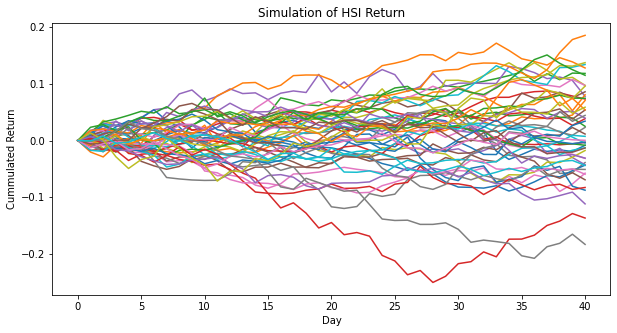

In [19]:
# Plots some simulated return of HSI
fig, ax = plt.subplots(figsize=(10,5))
for i in samples_hsi:
    ax.plot(i)
plt.xlabel('Day')
plt.ylabel('Cummulated Return')
plt.title('Simulation of HSI Return')


Text(0.5, 1.0, 'Simulation of N225 Return')

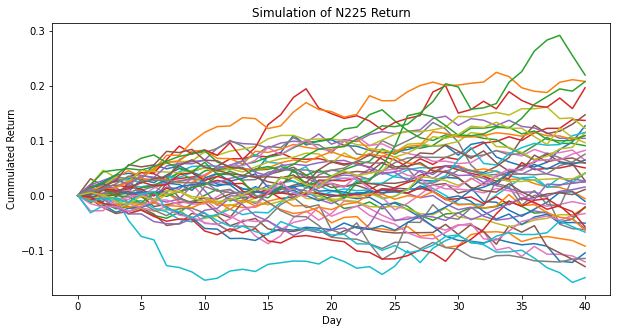

In [20]:
# Plots some simulated return of N225
fig, ax = plt.subplots(figsize=(10,5))
for i in samples_n225:
    ax.plot(i)
plt.xlabel('Day')
plt.ylabel('Cummulated Return')
plt.title('Simulation of N225 Return')

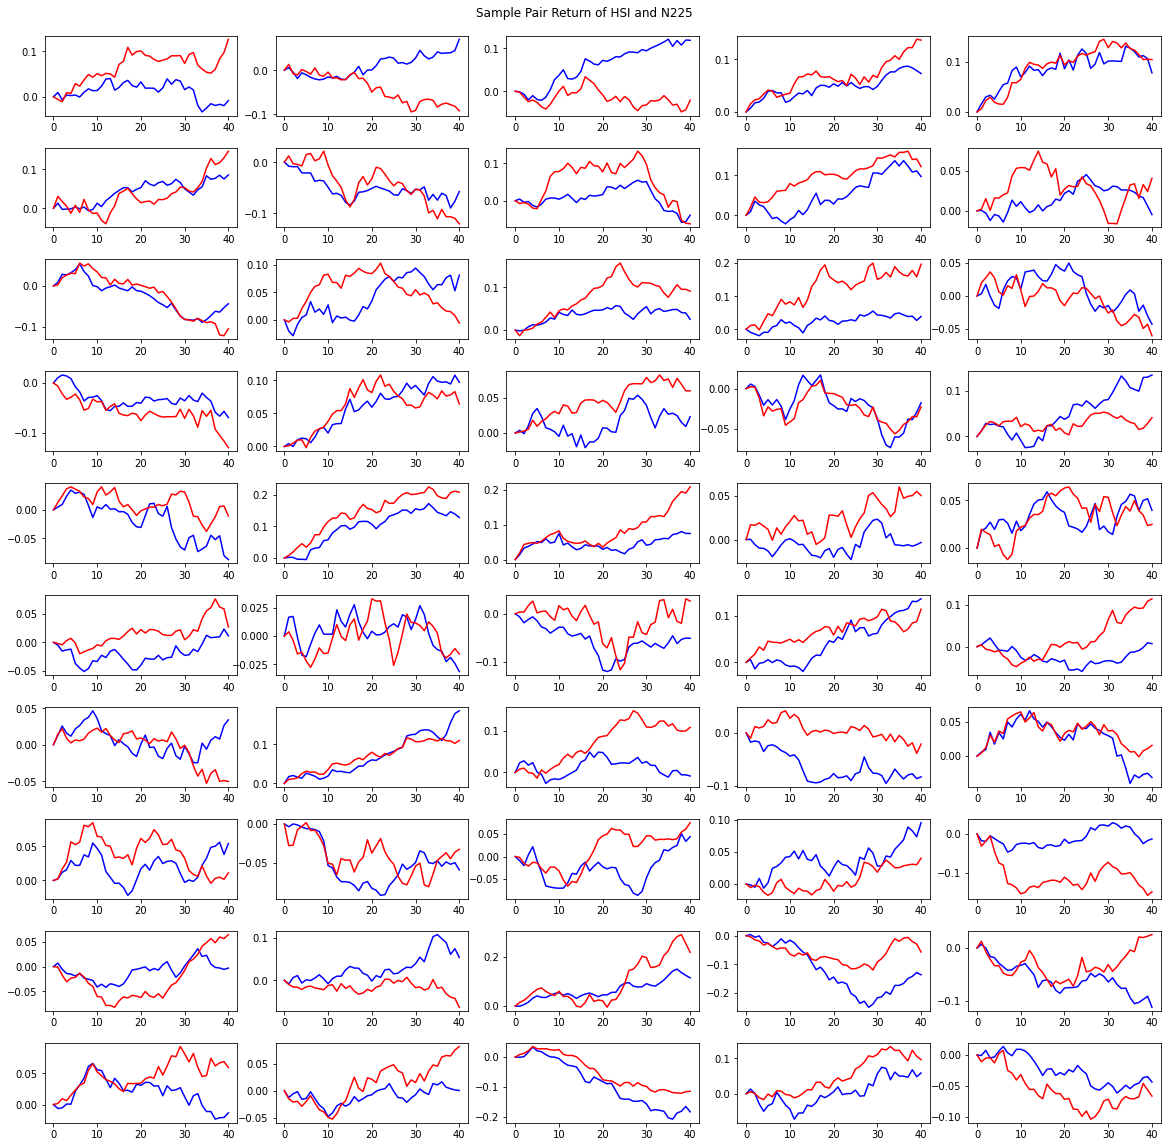

In [21]:
# Plot the cummulated return of HSI and N225 in pair
fig, ax = plt.subplots(10, 5, figsize=(20,20))
ax = ax.flatten()
for i in range(N_samples):
    ax[i].plot(samples_hsi[i], color='blue')
    ax[i].plot(samples_n225[i], color='red')
fig.suptitle('Sample Pair Return of HSI and N225', y=0.9)
fig.subplots_adjust(hspace=0.4)

From the above sample pair returns, we can see that the genereated returns show a certain degree of correlation. From the real historical data, we have known that HSI and N225 index are positively correlated. Therefore, the pattern of simulated returns meet our expectation. 

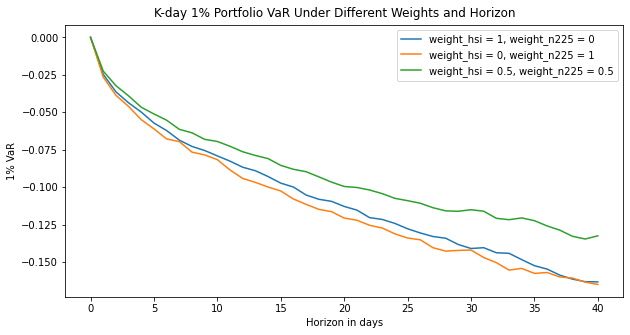

In [22]:
# Visulaize the K-day 1% VaR of Portfolio for different value of K
p = 0.01 # To calculate 1% VaR
fig, ax = plt.subplots(figsize=(10,5))
plt.subplots_adjust(hspace=0.35)
fig.suptitle('K-day 1% Portfolio VaR Under Different Weights and Horizon', y=0.93)
for weights in [(1,0), (0,1), (0.5,0.5)]:
    w_hsi, w_n225 = weights
    port_ret = w_hsi * returns_hsi + w_n225 * returns_n225   # calculate the portfolio return
    K_VaR = np.quantile(port_ret, p, axis = 0)
    ax.plot(K_VaR, label='weight_hsi = {}, weight_n225 = {}'.format(w_hsi, w_n225))
ax.set_xlabel("Horizon in days")
ax.set_ylabel("1% VaR")
ax.legend()

In the above figure, we can see the effect of diversification on VaR of return of a portfolio. When the portfolio contains two assets, the VaR of return is higher that those with single asset, which means that the risk of diversified protfolio is lower in terms of VaR.